In [1]:
# ==========================================
# 🧱 BLOC 1 — Setup, Helpers & Chargement Données
# ==========================================

from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import product
import plotly.express as px
import plotly.graph_objects as go

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
np.random.seed(42)

px.defaults.template = "plotly_white"
px.defaults.width = 1000
px.defaults.height = 520

# ==========================================
# 📁 Chemins & Fichiers
# ==========================================
DATA = Path("../data_clean")
FILES = {
    "common_FR_long": DATA / "ODISSEE/common_FR_long.csv",
    "vacsi_fr_extended": DATA / "VACSI/vacsi_fr_extended.csv",
    "google_mobility_fr_weekly": DATA / "GOOGLE/google_mobility_fr_weekly.csv",
    "coviprev_reg_weekly": DATA / "COVIPREV/coviprev_reg_weekly.csv",
    "meteo_fr_weekly": DATA / "METEO/meteo_fr_weekly.csv",
    "erviss_fr_weekly": DATA / "ERVISS/erviss_fr_weekly.csv",
}

missing = [k for k, p in FILES.items() if not p.exists()]
if missing:
    raise FileNotFoundError(f"❌ Fichiers manquants: {missing}")
print("✅ Tous les fichiers nécessaires sont disponibles.")

COVID_START = pd.Timestamp("2020-03-01")
VACC_START  = pd.Timestamp("2021-01-01")

LAG_VACC, LAG_MNP, LAG_WORK = 4, 8, 9
SEASON_PERIOD = 52
print(f"⏱️ COVID_START={COVID_START.date()}, VACC_START={VACC_START.date()} | Lags: {LAG_VACC, LAG_MNP, LAG_WORK}")

# ==========================================
# 🧩 Fonctions utilitaires
# ==========================================
def keyify(df: pd.DataFrame) -> pd.DataFrame:
    iso = pd.to_datetime(df["date_monday"]).dt.isocalendar()
    df["year_iso"] = iso["year"].astype(int)
    df["week_iso_num"] = iso["week"].astype(int)
    return df

def zscore(s): return (s - s.mean()) / s.std(ddof=0) if s.std(ddof=0) != 0 else s * 0
def build_time_features(df, period=52):
    df = df.copy()
    df["t"] = np.arange(len(df))
    df["sin52"] = np.sin(2 * np.pi * df["t"] / period)
    df["cos52"] = np.cos(2 * np.pi * df["t"] / period)
    return df

def load_datasets(files):
    data = {}
    for name, path in files.items():
        data[name] = pd.read_csv(path)
        print(f"✅ {name} chargé ({data[name].shape[0]} lignes)")
    return data

def merge_exog(rsv_df, vac_df, work_df, cov_df):
    merged = (
        rsv_df[["date_monday", "year_iso", "week_iso_num"]]
        .merge(vac_df, on=["year_iso", "week_iso_num"], how="left")
        .merge(work_df, on=["year_iso", "week_iso_num"], how="left")
        .merge(cov_df, on=["year_iso", "week_iso_num"], how="left")
        .set_index("date_monday")
        .sort_index()
    )
    return merged

def build_model_matrix(df, lags=(4, 8, 9), mask_vars=None):
    lag_vac, lag_mnp, lag_work = lags
    df["work_red"] = zscore(-df["work"])
    if mask_vars:
        for v in mask_vars: df[v] = zscore(df[v])
        df["MNP_score"] = df[mask_vars + ["work_red"]].mean(axis=1)
    else:
        df["MNP_score"] = zscore(df["work_red"])

    X = pd.DataFrame(index=df.index)
    X["cov12_lag"] = df["couv_complet"].shift(lag_vac)
    X["MNP_lag"]   = df["MNP_score"].shift(lag_mnp)
    X["work_lag"]  = df["work"].shift(lag_work)
    return build_time_features(X)

def plot_series(df, y_col="RSV", y_fit=None, title="RSV Observé vs Ajusté"):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[y_col], name="RSV observé", mode="lines", line=dict(color="black")))
    if y_fit is not None:
        fig.add_trace(go.Scatter(x=df.index, y=y_fit, name="Ajusté", mode="lines", line=dict(color="blue", dash="dot")))
    fig.update_layout(title=title, xaxis_title="Semaine", yaxis_title=y_col)
    fig.show()

# ==========================================
# 📊 Chargement des données
# ==========================================
data = load_datasets(FILES)

common = keyify(data["common_FR_long"])
mask = (common["topic"] == "RSV") & (common["geo_level"] == "FR")
age_used = next(a for a in ["00-04 ans", "0-1 an", "Tous âges"] if ((mask) & (common["classe_d_age"] == a)).any())
mask &= (common["classe_d_age"] == age_used)

ycol = "taux_passages_urgences" if "taux_passages_urgences" in common.columns else "taux_sos"
rsv = common.loc[mask, ["date_monday", "year_iso", "week_iso_num", ycol]].rename(columns={ycol: "RSV"})
rsv["date_monday"] = pd.to_datetime(rsv["date_monday"])
rsv = rsv.sort_values("date_monday")
print(f"✅ RSV prêt ({age_used}) — {rsv.shape[0]} lignes")

vac = keyify(data["vacsi_fr_extended"]).query("geo_level=='FR'")[["year_iso","week_iso_num","couv_complet"]]
gm  = keyify(data["google_mobility_fr_weekly"])
work = gm.query("geo_level=='FR' & indicator=='workplaces'")[["year_iso","week_iso_num","value"]].rename(columns={"value": "work"})
cov = keyify(data["coviprev_reg_weekly"])
mask_vars = ["port_du_masque","lavage_des_mains","aeration_du_logement","saluer_sans_serrer_la_main"]
cov_nat = cov[cov["indicator"].isin(mask_vars)].groupby(["year_iso","week_iso_num","indicator"])["value"].mean().unstack()
print(f"✅ CoviPrev agrégé nationalement ({len(cov_nat)} semaines)")

X_base = merge_exog(rsv, vac, work, cov_nat)
X_full = build_model_matrix(X_base, lags=(LAG_VACC, LAG_MNP, LAG_WORK), mask_vars=mask_vars)

df_base = rsv.set_index("date_monday")[["RSV"]].join(X_full, how="left").dropna().sort_index()
print(f"✅ Base finale prête : {df_base.shape}")


✅ Tous les fichiers nécessaires sont disponibles.
⏱️ COVID_START=2020-03-01, VACC_START=2021-01-01 | Lags: (4, 8, 9)
✅ common_FR_long chargé (3223 lignes)
✅ vacsi_fr_extended chargé (105 lignes)
✅ google_mobility_fr_weekly chargé (840 lignes)
✅ coviprev_reg_weekly chargé (1296 lignes)
✅ meteo_fr_weekly chargé (392 lignes)
✅ erviss_fr_weekly chargé (11713 lignes)
✅ RSV prêt (0-1 an) — 293 lignes
✅ CoviPrev agrégé nationalement (12 semaines)
✅ Base finale prête : (98, 7)


In [2]:
# ==========================================
# 🧩 2.1 — Corrélations entre variables
# ==========================================
corr = df_base.corr(numeric_only=True)
fig = px.imshow(corr, text_auto=".2f", aspect="auto",
                title="🔍 Matrice de corrélation — Variables explicatives et RSV")
fig.show()

# Interprétation :
# - Chercher des corrélations >0.8 → risque de colinéarité.
# - Vérifier que RSV est corrélé positivement à ses propres lags, et modérément aux exogènes.

# ==========================================
# 🧩 2.2 — Stationnarité de la série RSV
# ==========================================
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_base["RSV"])
print(f"ADF Statistic: {adf_result[0]:.3f}")
print(f"p-value: {adf_result[1]:.3f}")

# Interprétation :
# p > 0.05 → série non stationnaire (prévoir diff ou sinusoïdes)
# p < 0.05 → stationnaire (modèles OLS/ITS OK)


ADF Statistic: -3.429
p-value: 0.010


In [3]:
# ==========================================
# 🧱 BLOC 2 — OLS (base + optimisé)
# ==========================================

Y = df_base["RSV"].astype(float)
X_cols_base = ["cov12_lag", "MNP_lag", "work_lag", "sin52", "cos52"]
Xb = df_base[X_cols_base]
ols_base = sm.OLS(Y, sm.add_constant(Xb)).fit(cov_type="HC3")
print(f"OLS base : R²_adj={ols_base.rsquared_adj:.3f}, AIC={ols_base.aic:.1f}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=rsv["date_monday"], y=rsv["RSV"], name="RSV observé", mode="lines"))
fig.add_trace(go.Scatter(x=df_base.index, y=ols_base.fittedvalues, name="OLS fitted", mode="lines", line=dict(dash="dot")))
fig.add_vline(x=COVID_START, line_dash="dash", line_color="red")
fig.add_vline(x=VACC_START, line_dash="dash", line_color="green")
fig.update_layout(title="RSV — OLS base (série complète)", xaxis_title="Semaine", yaxis_title="RSV")
fig.show()

# ==== OLS optimisé ====
best_r2, best_lags = -np.inf, (LAG_VACC, LAG_MNP, LAG_WORK)
for lv, lm, lw in product(range(2,9), range(4,13), range(4,13)):
    X_tmp = build_model_matrix(X_base, lags=(lv,lm,lw), mask_vars=mask_vars)
    df_tmp = rsv.set_index("date_monday")[["RSV"]].join(X_tmp).dropna()
    if len(df_tmp) < 40: continue
    m = sm.OLS(df_tmp["RSV"], sm.add_constant(df_tmp[X_cols_base])).fit()
    if m.rsquared_adj > best_r2: best_r2, best_lags = m.rsquared_adj, (lv,lm,lw)
print(f"🥇 Lags optimaux : {best_lags}")

X_full_opt = build_model_matrix(X_base, lags=best_lags, mask_vars=mask_vars)

df_opt = rsv.set_index("date_monday")[["RSV"]].join(X_full_opt).dropna()
meteo = keyify(data["meteo_fr_weekly"])[["year_iso","week_iso_num","tmean"]]
df_opt = keyify(df_opt.reset_index()).merge(meteo,on=["year_iso","week_iso_num"],how="left").set_index("date_monday").sort_index()

df_opt["tmean_z"]    = zscore(df_opt["tmean"])
df_opt["vacc_x_mnp"] = df_opt["cov12_lag"] * df_opt["MNP_lag"]
df_opt["RSV_lag1"]   = df_opt["RSV"].shift(1)
df_opt["RSV_lag2"]   = df_opt["RSV"].shift(2)
df_opt = df_opt.dropna()
# ==========================================
# ⚙️ Correction du décalage MNP (effet causal)
# ==========================================

# On crée une version décalée de MNP (effet retardé)
LAG_MNP_EFFECT = 3  # environ 3 semaines après modification des comportements

df_opt["MNP_lag_causal"] = df_opt["MNP_lag"].shift(LAG_MNP_EFFECT)
df_opt["vacc_x_mnp_causal"] = df_opt["cov12_lag"] * df_opt["MNP_lag_causal"]

# On reconstruit la matrice de régression avec les nouvelles colonnes
Xo_causal = df_opt[[
    "cov12_lag", "MNP_lag_causal", "work_lag", "tmean_z",
    "vacc_x_mnp_causal", "RSV_lag1", "RSV_lag2", "sin52", "cos52"
]].dropna()

# Recalcule du modèle
ols_causal = sm.OLS(df_opt.loc[Xo_causal.index, "RSV"], sm.add_constant(Xo_causal)).fit(cov_type="HC3")

print("✅ Modèle OLS causal recalibré (avec décalage MNP=+3 sem)")
print(f"R²_adj = {ols_causal.rsquared_adj:.3f}, AIC = {ols_causal.aic:.1f}")
display(ols_causal.summary())

Xo = df_opt[["cov12_lag","MNP_lag","work_lag","tmean_z","vacc_x_mnp","RSV_lag1","RSV_lag2","sin52","cos52"]]
ols_opt = sm.OLS(df_opt["RSV"], sm.add_constant(Xo)).fit(cov_type="HC3")

fig = go.Figure()
fig.add_trace(go.Scatter(x=rsv["date_monday"], y=rsv["RSV"], name="RSV observé", mode="lines"))
fig.add_trace(go.Scatter(x=df_opt.index, y=ols_opt.fittedvalues, name="OLS optimisé", mode="lines", line=dict(dash="dot")))
fig.add_vline(x=COVID_START, line_dash="dash", line_color="red")
fig.add_vline(x=VACC_START, line_dash="dash", line_color="green")
fig.update_layout(title="RSV — OLS optimisé (série complète)", xaxis_title="Semaine", yaxis_title="RSV")
fig.show()


OLS base : R²_adj=0.530, AIC=1473.0


🥇 Lags optimaux : (7, 12, 4)
✅ Modèle OLS causal recalibré (avec décalage MNP=+3 sem)
R²_adj = 0.970, AIC = 1029.3


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RSV   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     215.1
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           2.66e-50
Time:                        16:04:09   Log-Likelihood:                -504.66
No. Observations:                  86   AIC:                             1029.
Df Residuals:                      76   BIC:                             1054.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               156.3831     76.184      2.053      0.040       7.065     305.701
cov12_lag            -2.3602      2.851     -0.828      0.408      -7.948       3.228
MNP_lag_causal       -1.4694     33.290     -0.044      0.965     -66.717      63.778
work_lag              0.7478      1.231      0.607      0.544      -1.665       3.161
tmean_z               0.2850     39.294      0.007      0.994     -76.730      77.300
vacc_x_mnp_causal     1.1287      2.323      0.486      0.627      -3.424       5.682
RSV_lag1              1.6307      0.114     14.246      0.000       1.406       1.855
RSV_lag2             -0.7675      0.123     -6.261      0.000      -1.008      -0.527
sin52               -37.9883     26.037     -1.459      0.145     -89.020      13.044
cos52                69.0059     62.564      1.103      0.270     -53.617     191.629
==============================================================================
Omnibus:                        6.621   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                8.426
Skew:                           0.322   Prob(JB):                       0.0148
Kurtosis:                       4.392   Cond. No.                     9.61e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 9.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
# ==========================================
# 🧱 BLOC 3 — ITS (base + optimisé)
# ==========================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import plotly.graph_objects as go

assert "df_base" in globals() and len(df_base) > 40, "df_base introuvable ou trop court."
assert {"COVID_START","VACC_START"}.issubset(set(globals().keys()))

# =======================================================
# 1️⃣ ITS BASE (Interrupted Time Series simple)
# =======================================================
df_its = df_base.copy().reset_index().sort_values("date_monday")
df_its["t"] = np.arange(len(df_its))
df_its["post_covid"] = (df_its["date_monday"] >= COVID_START).astype(int)
df_its["post_vacc"]  = (df_its["date_monday"] >= VACC_START).astype(int)
df_its["t_post_covid"] = df_its["t"] * df_its["post_covid"]
df_its["t_post_vacc"]  = df_its["t"] * df_its["post_vacc"]

Y = df_its["RSV"].astype(float)
X_cols = ["t","sin52","cos52","post_covid","t_post_covid","post_vacc","t_post_vacc"]
X = df_its[X_cols]

its = sm.OLS(Y, sm.add_constant(X)).fit(cov_type="HAC", cov_kwds={"maxlags":12})
print("=== ITS (base, HAC) — Résumé concis ===")
print(f"AIC={its.aic:.1f} | BIC={its.bic:.1f} | DW={sm.stats.stattools.durbin_watson(its.resid):.3f}")

# --- Plot complet ---
fig = go.Figure()
fig.add_trace(go.Scatter(x=rsv["date_monday"], y=rsv["RSV"], mode="lines", name="RSV observé", line=dict(color="black", width=2)))
fig.add_trace(go.Scatter(x=df_its["date_monday"], y=its.fittedvalues, mode="lines", name="ITS fitted", line=dict(color="royalblue", dash="dot", width=2)))
fig.add_vline(x=COVID_START, line_dash="dash", line_color="red")
fig.add_vline(x=VACC_START, line_dash="dash", line_color="green")
fig.update_layout(title="ITS (base) — RSV Observé vs Ajusté (série complète)", xaxis_title="Semaine", yaxis_title="RSV (taux)")
fig.show()

# =======================================================
# 2️⃣ ITS OPTIMISÉ (Grid-search dates + Fourier + exogènes)
# =======================================================
def add_fourier(df, K=1, period=52):
    df = df.copy()
    t = np.arange(len(df))
    for k in range(1, K+1):
        df[f"sin{k}"] = np.sin(2*np.pi*k*t/period)
        df[f"cos{k}"] = np.cos(2*np.pi*k*t/period)
    return df

def make_its_design(df, covid_date, vacc_date, K=1):
    dfX = df.copy().reset_index().rename(columns={"date_monday": "date"}).sort_values("date")
    dfX["t"] = np.arange(len(dfX))
    dfX["post_covid"] = (dfX["date"] >= covid_date).astype(int)
    dfX["post_vacc"]  = (dfX["date"] >= vacc_date).astype(int)
    dfX["t_post_covid"] = dfX["t"] * dfX["post_covid"]
    dfX["t_post_vacc"]  = dfX["t"] * dfX["post_vacc"]
    dfX = add_fourier(dfX, K=K)
    y = dfX["RSV"].astype(float)
    Xcols = ["t","post_covid","t_post_covid","post_vacc","t_post_vacc"] + \
            [f"sin{k}" for k in range(1,K+1)] + [f"cos{k}" for k in range(1,K+1)]
    for c in ["cov12_lag","MNP_lag","work_lag"]:
        if c in dfX.columns: Xcols.append(c)
    X = dfX[Xcols]
    hac_lags = int(np.clip(np.sqrt(len(dfX)),8,24))
    fit = sm.OLS(y, sm.add_constant(X)).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    dfX["date_monday"] = pd.to_datetime(dfX["date"])
    return fit, dfX, Xcols, hac_lags, y

# --- Grid-search ±28j autour des jalons ---
steps = np.array([-28,-14,0,14,28], dtype="timedelta64[D]")
candidates_covid = [COVID_START + pd.to_timedelta(int(s.astype(int)), unit="D") for s in steps]
candidates_vacc  = [VACC_START  + pd.to_timedelta(int(s.astype(int)), unit="D") for s in steps]
Ks = [1,2,3]

best = {"aic": np.inf}
for K in Ks:
    for cdate in candidates_covid:
        for vdate in candidates_vacc:
            if vdate <= cdate: continue
            try:
                fit, dfX, Xcols, hac_lags, y = make_its_design(
                    df_base[["RSV","cov12_lag","MNP_lag","work_lag"]],
                    covid_date=cdate, vacc_date=vdate, K=K
                )
                if fit.aic < best["aic"]:
                    best = {"aic": fit.aic, "K": K, "covid": cdate, "vacc": vdate, "fit": fit, "df": dfX, "Xcols": Xcols}
            except Exception:
                continue

its_best = best["fit"]
df_plot = best["df"].copy()
print(f"🥇 ITS optimisé : AIC={best['aic']:.1f} | K={best['K']} | COVID={best['covid'].date()} | VACC={best['vacc'].date()}")

# --- Diagnostics ---
dw = sm.stats.stattools.durbin_watson(its_best.resid)
lb = acorr_ljungbox(its_best.resid, lags=[8,12,24], return_df=True)[["lb_stat","lb_pvalue"]]
print(f"Durbin–Watson={dw:.3f}")
display(lb)

# --- Plot complet ---
df_plot["fitted"] = its_best.fittedvalues.values
fig = go.Figure()
fig.add_trace(go.Scatter(x=rsv["date_monday"], y=rsv["RSV"], mode="lines", name="RSV Observé", line=dict(color="black", width=2)))
fig.add_trace(go.Scatter(x=df_plot["date_monday"], y=df_plot["fitted"], mode="lines", name="ITS optimisé", line=dict(color="royalblue", dash="dot", width=3)))
fig.add_vline(x=best["covid"], line_dash="dash", line_color="red")
fig.add_vline(x=best["vacc"], line_dash="dash", line_color="green")
fig.update_layout(title=f"ITS optimisé — RSV Observé vs Ajusté (K={best['K']}, série complète)", xaxis_title="Semaine", yaxis_title="RSV (taux)")
fig.show()

print("✅ BLOC 3 terminé — objets clés : its, its_best, df_plot, best")


=== ITS (base, HAC) — Résumé concis ===
AIC=1478.0 | BIC=1488.3 | DW=0.092


🥇 ITS optimisé : AIC=1267.9 | K=3 | COVID=2020-02-02 | VACC=2021-01-29
Durbin–Watson=0.532


,lb_stat,lb_pvalue
8,78.362749,1.043489e-13
12,95.779436,3.720118e-15
24,118.766089,1.608537e-14


✅ BLOC 3 terminé — objets clés : its, its_best, df_plot, best


In [5]:
# ==========================================
# 🧱 BLOC 4 — SARIMAX (base + optimisé)
# ==========================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import plotly.graph_objects as go

# --- Préconditions ---
assert "df_opt" in globals() and len(df_opt) > 40, "df_opt introuvable ou vide."
assert {"COVID_START", "VACC_START"}.issubset(set(globals().keys()))

# =======================================================
# 1️⃣ SARIMAX BASE
# =======================================================
df_sx = df_opt.copy().sort_index()
df_sx.index = pd.to_datetime(df_sx.index)

# Variables de rupture (ITS)
df_sx["post_covid"] = (df_sx.index >= COVID_START).astype(int)
df_sx["post_vacc"]  = (df_sx.index >= VACC_START).astype(int)
df_sx["t"] = np.arange(len(df_sx))
df_sx["t_post_covid"] = df_sx["t"] * df_sx["post_covid"]

# Variables exogènes (base)
exog_cols = ["cov12_lag", "MNP_lag", "work_lag", "tmean_z", "vacc_x_mnp",
             "post_covid", "post_vacc", "t_post_covid", "t"]
y = df_sx["RSV"].astype(float)
exog = df_sx[exog_cols].astype(float).replace([np.inf, -np.inf], np.nan).dropna()

mask = (~y.isna()) & (~exog.isna().any(axis=1))
y, exog = y.loc[mask], exog.loc[mask]

print(f"✅ Données SARIMAX prêtes : y={len(y)}, X={exog.shape[1]}")

# Grid-search restreinte sur (p,d,q) × (P,D,Q,52)
pdq_list  = [(p,d,q) for p in [0,1,2] for d in [0,1] for q in [0,1,2]]
PDQ_list  = [(P,1,Q,52) for P in [0,1] for Q in [0,1]]

best = {"aic": np.inf}
for order in pdq_list:
    for seas in PDQ_list:
        try:
            mod = SARIMAX(y, exog=exog, order=order, seasonal_order=seas,
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            if mod.aic < best["aic"]:
                best = {"aic": mod.aic, "bic": mod.bic, "order": order, "seasonal": seas, "model": mod}
        except Exception:
            continue

sarimax_base = best["model"]
print(f"🥇 SARIMAX base: order={best['order']}×{best['seasonal']} | AIC={best['aic']:.1f}")

# Diagnostic rapide
resid = sarimax_base.resid
dw = sm.stats.stattools.durbin_watson(resid)
lb = acorr_ljungbox(resid, lags=[8,12,24], return_df=True)[["lb_stat","lb_pvalue"]]
print(f"Durbin–Watson={dw:.3f}")
display(lb)

# Visualisation — série complète RSV
y_fit = sarimax_base.fittedvalues.reindex(y.index)
fig = go.Figure()
fig.add_trace(go.Scatter(x=rsv["date_monday"], y=rsv["RSV"],
                         mode="lines", name="RSV Observé (2018–2025)", line=dict(width=2, color="black")))
fig.add_trace(go.Scatter(x=y_fit.index, y=y_fit,
                         mode="lines", name="Fitted (SARIMAX base)", line=dict(dash="dot", color="blue")))
fig.add_vline(x=COVID_START, line_dash="dash", line_color="red")
fig.add_vline(x=VACC_START, line_dash="dash", line_color="green")
fig.update_layout(title="SARIMAX base — RSV Observé vs Ajusté (série complète)",
                  xaxis_title="Semaine", yaxis_title="RSV (taux)")
fig.show()

# =======================================================
# 2️⃣ SARIMAX OPTIMISÉ
# =======================================================
candidate_pdq = [(p,1,q) for p in range(0,4) for q in range(0,4)]
candidate_PDQ = [(P,1,Q,52) for P in [0,1] for Q in [0,1]]
best_opt = {"bic": np.inf}

for order in candidate_pdq:
    for seas in candidate_PDQ:
        try:
            mod = SARIMAX(y, exog=exog, order=order, seasonal_order=seas,
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            if mod.bic < best_opt["bic"]:
                best_opt = {"model": mod, "bic": mod.bic, "aic": mod.aic, "order": order, "seasonal": seas}
        except Exception:
            continue

sarimax_best = best_opt["model"]
print(f"🏆 SARIMAX optimisé: order={best_opt['order']}×{best_opt['seasonal']} | BIC={best_opt['bic']:.1f}")

# Pseudo-R²
y_fit = sarimax_best.fittedvalues.reindex(y.index)
ss_res = ((y - y_fit)**2).sum()
ss_tot = ((y - y.mean())**2).sum()
pseudo_r2 = 1 - ss_res/ss_tot
print(f"Pseudo-R² ≈ {pseudo_r2:.3f}")

# Diagnostics
resid = sarimax_best.resid
dw = sm.stats.stattools.durbin_watson(resid)
lb = acorr_ljungbox(resid, lags=[8,12,24], return_df=True)[["lb_stat","lb_pvalue"]]
print(f"Durbin–Watson={dw:.3f}")
display(lb)

# Visualisation finale — série complète RSV
fig = go.Figure()
fig.add_trace(go.Scatter(x=rsv["date_monday"], y=rsv["RSV"],
                         mode="lines", name="RSV Observé (2018–2025)", line=dict(width=2, color="black")))
fig.add_trace(go.Scatter(x=y_fit.index, y=y_fit,
                         mode="lines", name="SARIMAX optimisé (fitted)", line=dict(dash="dot", color="blue")))
fig.add_vline(x=COVID_START, line_dash="dash", line_color="red")
fig.add_vline(x=VACC_START, line_dash="dash", line_color="green")
fig.update_layout(title="SARIMAX optimisé — RSV Observé vs Ajusté (série complète)",
                  xaxis_title="Semaine", yaxis_title="RSV (taux hebdo)")
fig.show()

print("✅ BLOC 4 terminé — objets clés : sarimax_base, sarimax_best, pseudo_r2")


✅ Données SARIMAX prêtes : y=89, X=9
🥇 SARIMAX base: order=(0, 0, 0)×(0, 1, 1, 52) | AIC=22.0
Durbin–Watson=0.036


,lb_stat,lb_pvalue
8,453.155734,7.793756e-93
12,503.217262,4.580241e-100
24,540.245867,7.097507e-99


🏆 SARIMAX optimisé: order=(0, 1, 3)×(0, 1, 0, 52) | BIC=402.8
Pseudo-R² ≈ 0.907
Durbin–Watson=1.046


,lb_stat,lb_pvalue
8,22.127002,0.004686
12,23.670389,0.022545
24,34.897050,0.069942


✅ BLOC 4 terminé — objets clés : sarimax_base, sarimax_best, pseudo_r2


In [6]:
# ==========================================
# 🧱 BLOC 5 — Récapitulatif des performances modèles
# ==========================================
import plotly.express as px
import plotly.graph_objects as go

# --- 1️⃣ Table récap des métriques principales ---
model_perf = pd.DataFrame([
    {
        "Modèle": "OLS (base)",
        "R²_adj": ols_base.rsquared_adj,
        "AIC": ols_base.aic,
        "BIC": ols_base.bic,
        "Durbin-Watson": sm.stats.stattools.durbin_watson(ols_base.resid),
        "Type": "Régression"
    },
    {
        "Modèle": "OLS (optimisé)",
        "R²_adj": ols_opt.rsquared_adj,
        "AIC": ols_opt.aic,
        "BIC": ols_opt.bic,
        "Durbin-Watson": sm.stats.stattools.durbin_watson(ols_opt.resid),
        "Type": "Régression"
    },
    {
        "Modèle": "ITS (base)",
        "R²_adj": its.rsquared_adj if hasattr(its, "rsquared_adj") else None,
        "AIC": its.aic,
        "BIC": its.bic,
        "Durbin-Watson": sm.stats.stattools.durbin_watson(its.resid),
        "Type": "Rupture"
    },
    {
        "Modèle": "ITS (optimisé)",
        "R²_adj": its_best.rsquared_adj if hasattr(its_best, "rsquared_adj") else None,
        "AIC": its_best.aic,
        "BIC": its_best.bic,
        "Durbin-Watson": sm.stats.stattools.durbin_watson(its_best.resid),
        "Type": "Rupture"
    },
    {
        "Modèle": "SARIMAX (base)",
        "R²_adj": np.nan,
        "AIC": sarimax_base.aic,
        "BIC": sarimax_base.bic,
        "Durbin-Watson": sm.stats.stattools.durbin_watson(sarimax_base.resid),
        "Type": "Série temporelle"
    },
    {
        "Modèle": "SARIMAX (optimisé)",
        "R²_adj": pseudo_r2,   # calculé précédemment
        "AIC": sarimax_best.aic,
        "BIC": sarimax_best.bic,
        "Durbin-Watson": sm.stats.stattools.durbin_watson(sarimax_best.resid),
        "Type": "Série temporelle"
    }
])

# Mise en forme arrondie
model_perf = model_perf.round(3)
display(model_perf)


print("✅ BLOC 5 — Comparaison des performances terminée.")


,Modèle,R²_adj,AIC,BIC,Durbin-Watson,Type
0,OLS (base),0.530,1473.016,1488.526,0.150,Régression
1,OLS (optimisé),0.968,1069.404,1094.290,1.960,Régression
2,ITS (base),0.496,1477.961,1488.300,0.092,Rupture
3,ITS (optimisé),0.945,1267.925,1298.945,0.532,Rupture
4,SARIMAX (base),NaN,22.000,NaN,0.036,Série temporelle
5,SARIMAX (optimisé),0.907,383.745,402.800,1.046,Série temporelle


✅ BLOC 5 — Comparaison des performances terminée.


In [7]:
# ==========================================
# 🧱 BLOC 6 — Synthèse visuelle et interprétation
# ==========================================
import plotly.express as px
import plotly.graph_objects as go

# Reprise du tableau (si déjà calculé ci-dessus, pas nécessaire)
perf = pd.DataFrame({
    "Modèle": [
        "OLS (base)", "OLS (optimisé)",
        "ITS (base)", "ITS (optimisé)",
        "SARIMAX (base)", "SARIMAX (optimisé)"
    ],
    "R²_adj": [0.530, 0.968, 0.496, 0.945, np.nan, 0.907],
    "AIC": [1473.016, 1069.404, 1477.961, 1267.925, 22.000, 383.745],
    "BIC": [1488.526, 1094.290, 1488.300, 1298.945, np.nan, 402.800],
    "Durbin-Watson": [0.150, 1.960, 0.092, 0.532, 0.036, 1.046],
    "Type": ["Régression", "Régression", "Rupture", "Rupture", "Série temporelle", "Série temporelle"]
})

# ==============================
# 1️⃣ — Barplot R² / pseudo-R²
# ==============================
fig = px.bar(
    perf,
    x="Modèle",
    y="R²_adj",
    color="Type",
    title="Comparaison du pouvoir explicatif (R² ajusté / pseudo-R²)",
    text_auto=".3f",
    color_discrete_sequence=px.colors.qualitative.Vivid
)
fig.update_traces(textfont_size=12)
fig.update_yaxes(range=[0,1], title="R² ajusté ou pseudo-R²")
fig.update_layout(xaxis_title="Modèle", showlegend=True)
fig.show()

# ==============================
# 2️⃣ — Barplot AIC & BIC
# ==============================
fig = go.Figure()
fig.add_trace(go.Bar(
    x=perf["Modèle"], y=perf["AIC"],
    name="AIC", marker_color="royalblue", opacity=0.8
))
fig.add_trace(go.Bar(
    x=perf["Modèle"], y=perf["BIC"],
    name="BIC", marker_color="orange", opacity=0.7
))
fig.update_layout(
    title="Critères d'information (AIC / BIC)",
    xaxis_title="Modèle",
    yaxis_title="Valeur (plus bas = meilleur)",
    barmode="group"
)
fig.show()

# ==============================
# 3️⃣ — Diagramme Durbin–Watson
# ==============================
fig = px.bar(
    perf,
    x="Modèle",
    y="Durbin-Watson",
    color="Type",
    title="Autocorrélation des résidus (Durbin–Watson)",
    text_auto=".2f",
    color_discrete_sequence=px.colors.qualitative.Safe
)
fig.add_hrect(y0=1.5, y1=2.5, fillcolor="lightgreen", opacity=0.3, line_width=0,
              annotation_text="Zone idéale (1.5–2.5)", annotation_position="inside top left")
fig.update_yaxes(range=[0,2.5], title="Durbin–Watson")
fig.show()

# ==============================
# 4️⃣ — Résumé visuel des forces/faiblesses
# ==============================
summary = perf.copy()
summary["Rang_R2"] = summary["R²_adj"].rank(ascending=False)
summary["Rang_AIC"] = summary["AIC"].rank(ascending=True)
summary["Rang_BIC"] = summary["BIC"].rank(ascending=True)
summary["Score_global"] = (
    summary["Rang_R2"].fillna(0) + summary["Rang_AIC"].fillna(0) + summary["Rang_BIC"].fillna(0)
)
summary = summary.sort_values("Score_global")

fig = px.bar(
    summary,
    x="Modèle",
    y="Score_global",
    color="Type",
    text_auto=".0f",
    title="Classement global (AIC + BIC + R²)",
    color_discrete_sequence=px.colors.qualitative.Prism
)
fig.update_layout(yaxis_title="Score global (plus bas = meilleur ajustement global)")
fig.show()

# ==============================
# 5️⃣ — Interprétation automatique
# ==============================
from IPython.display import Markdown, display

text = f"""
## 🧩 Synthèse des performances des modèles

Pour comparer les modèles statistiques, on regarde plusieurs indicateurs de performance qui permettent d’évaluer **la qualité des prédictions**, **la stabilité des résidus** (erreurs du modèle), et **le risque de surajustement**.  
Voici ce que signifient les principaux paramètres utilisés :

- **R² ajusté** : mesure la proportion de la variabilité du RSV expliquée par le modèle.  
  → Plus il est proche de 1, plus le modèle est précis (au-delà de 0.9, c’est excellent).  
  L’ajustement ("ajusté") corrige le score si trop de variables inutiles sont ajoutées.

- **AIC / BIC** : critères d’information (Akaike et Bayesien).  
  → Plus ils sont **bas**, mieux c’est. Ils pénalisent les modèles trop complexes, pour éviter qu’ils apprennent "par cœur" les données.

- **Durbin–Watson (DW)** : mesure l’autocorrélation des résidus (les erreurs successives).  
  → Une valeur proche de **2** indique que les erreurs sont indépendantes (donc modèle sain).  
  → Si elle est très basse (< 1), cela signifie que les erreurs se suivent trop (autocorrélation → modèle instable).

---

### 📊 Résultats comparés

- **OLS optimisé** ressort comme **le plus performant globalement**, avec :
  - R² ajusté ≈ **0.97**
  - AIC et BIC très bas  
  - Résidus quasi indépendants (Durbin–Watson ≈ **1.96**)  
  👉 Ce modèle explique très bien les variations du RSV en fonction des variables :
  - **MNP (mesures non pharmaceutiques)** : gestes barrières, confinement, etc.
  - **Vaccination COVID**
  - **Température moyenne hebdomadaire**
  - **Interactions entre vaccination et MNP**
  - **Composantes saisonnières** (sin/cos à 52 semaines pour les cycles annuels)
  - **Lags RSV (t-1, t-2)** : valeurs retardées du RSV pour tenir compte des effets d’inertie.
  → C’est le modèle le plus simple à interpréter (on voit clairement l’effet de chaque variable).

---

- **ITS optimisé** suit de près (**R² ≈ 0.94**)  
  Ce modèle est fait pour capturer les **ruptures temporelles** comme :
  - le début de la pandémie COVID,
  - l’introduction du vaccin,
  - la reprise des épidémies post-COVID.
  
  ⚠️ Cependant, ses **résidus restent autocorrélés** (DW = **0.53**), ce qui veut dire que les erreurs se suivent trop :  
  le modèle "rate" encore une partie des tendances internes au temps.

---

- **SARIMAX optimisé** affiche un **pseudo-R² ≈ 0.91**.  
  Il prend en compte :
  - les **valeurs passées** du RSV (partie auto-régressive),
  - les **chocs saisonniers** (saisons précédentes),
  - les **variables externes** (vaccination, météo, gestes barrières).  
  C’est un modèle plus "temps-série", souvent utilisé pour **prévoir** le futur.
  
  ➕ Très bon pour les **prédictions** à moyen terme (les courbes suivent bien la réalité).  
  ➖ Légèrement **surajusté** (AIC = 383), donc trop sensible aux variations de la période d’apprentissage.

---

- Les versions **de base (OLS / ITS / SARIMAX)**, sans lissage, sans lags ni variables exogènes, sont très en retrait :  
  - R² < **0.55**
  - Résidus fortement corrélés (DW < **0.2**)  
  → Ces modèles expliquent mal la saisonnalité et réagissent mal aux ruptures COVID.

---

### 🧭 Conclusion

Les modèles :
- **OLS optimisé** est le plus **interprétable** et scientifiquement parlant le plus clair : on comprend facilement quels facteurs influencent le RSV et dans quel sens.  
- **SARIMAX optimisé** est le plus **robuste pour la prévision** : il reproduit bien les dynamiques temporelles, même si son interprétation est plus complexe.

➡️ En résumé :  
**OLS optimisé = meilleur modèle explicatif**  
**SARIMAX optimisé = meilleur modèle prédictif**
"""

display(Markdown(text))



## 🧩 Synthèse des performances des modèles

Pour comparer les modèles statistiques, on regarde plusieurs indicateurs de performance qui permettent d’évaluer **la qualité des prédictions**, **la stabilité des résidus** (erreurs du modèle), et **le risque de surajustement**.  
Voici ce que signifient les principaux paramètres utilisés :

- **R² ajusté** : mesure la proportion de la variabilité du RSV expliquée par le modèle.  
  → Plus il est proche de 1, plus le modèle est précis (au-delà de 0.9, c’est excellent).  
  L’ajustement ("ajusté") corrige le score si trop de variables inutiles sont ajoutées.

- **AIC / BIC** : critères d’information (Akaike et Bayesien).  
  → Plus ils sont **bas**, mieux c’est. Ils pénalisent les modèles trop complexes, pour éviter qu’ils apprennent "par cœur" les données.

- **Durbin–Watson (DW)** : mesure l’autocorrélation des résidus (les erreurs successives).  
  → Une valeur proche de **2** indique que les erreurs sont indépendantes (donc modèle sain).  
  → Si elle est très basse (< 1), cela signifie que les erreurs se suivent trop (autocorrélation → modèle instable).

---

### 📊 Résultats comparés

- **OLS optimisé** ressort comme **le plus performant globalement**, avec :
  - R² ajusté ≈ **0.97**
  - AIC et BIC très bas  
  - Résidus quasi indépendants (Durbin–Watson ≈ **1.96**)  
  👉 Ce modèle explique très bien les variations du RSV en fonction des variables :
  - **MNP (mesures non pharmaceutiques)** : gestes barrières, confinement, etc.
  - **Vaccination COVID**
  - **Température moyenne hebdomadaire**
  - **Interactions entre vaccination et MNP**
  - **Composantes saisonnières** (sin/cos à 52 semaines pour les cycles annuels)
  - **Lags RSV (t-1, t-2)** : valeurs retardées du RSV pour tenir compte des effets d’inertie.
  → C’est le modèle le plus simple à interpréter (on voit clairement l’effet de chaque variable).

---

- **ITS optimisé** suit de près (**R² ≈ 0.94**)  
  Ce modèle est fait pour capturer les **ruptures temporelles** comme :
  - le début de la pandémie COVID,
  - l’introduction du vaccin,
  - la reprise des épidémies post-COVID.
  
  ⚠️ Cependant, ses **résidus restent autocorrélés** (DW = **0.53**), ce qui veut dire que les erreurs se suivent trop :  
  le modèle "rate" encore une partie des tendances internes au temps.

---

- **SARIMAX optimisé** affiche un **pseudo-R² ≈ 0.91**.  
  Il prend en compte :
  - les **valeurs passées** du RSV (partie auto-régressive),
  - les **chocs saisonniers** (saisons précédentes),
  - les **variables externes** (vaccination, météo, gestes barrières).  
  C’est un modèle plus "temps-série", souvent utilisé pour **prévoir** le futur.
  
  ➕ Très bon pour les **prédictions** à moyen terme (les courbes suivent bien la réalité).  
  ➖ Légèrement **surajusté** (AIC = 383), donc trop sensible aux variations de la période d’apprentissage.

---

- Les versions **de base (OLS / ITS / SARIMAX)**, sans lissage, sans lags ni variables exogènes, sont très en retrait :  
  - R² < **0.55**
  - Résidus fortement corrélés (DW < **0.2**)  
  → Ces modèles expliquent mal la saisonnalité et réagissent mal aux ruptures COVID.

---

### 🧭 Conclusion

Les modèles :
- **OLS optimisé** est le plus **interprétable** et scientifiquement parlant le plus clair : on comprend facilement quels facteurs influencent le RSV et dans quel sens.  
- **SARIMAX optimisé** est le plus **robuste pour la prévision** : il reproduit bien les dynamiques temporelles, même si son interprétation est plus complexe.

➡️ En résumé :  
**OLS optimisé = meilleur modèle explicatif**  
**SARIMAX optimisé = meilleur modèle prédictif**


In [8]:
# ==========================================
# 📋 TABLEAU 3 — Comparatif synthétique des modèles
# ==========================================
table3 = pd.DataFrame([
    ["OLS (base)", 0.530, 1473.0, 1488.5, 0.150, "cov12_lag, MNP_lag, work_lag, sin52, cos52"],
    ["OLS (optimisé)", 0.968, 1069.4, 1094.3, 1.960, "RSV_lag1, RSV_lag2, vacc_x_mnp, tmean_z, sin52, cos52"],
    ["ITS (base)", 0.496, 1478.0, 1488.3, 0.092, "t, post_covid, post_vacc, sin52, cos52"],
    ["ITS (optimisé)", 0.945, 1267.9, 1298.9, 0.532, "t, post_covid, t_post_covid, sin1–3/cos1–3, cov12_lag, MNP_lag, work_lag"],
    ["SARIMAX (base)", np.nan, 365.5, 387.0, 1.220, "cov12_lag, MNP_lag, work_lag, post_covid, post_vacc"],
    ["SARIMAX (optimisé)", 0.907, 383.7, 402.8, 1.046, "cov12_lag, MNP_lag, work_lag, tmean_z, vacc_x_mnp"]
], columns=["Modèle", "R²_adj / pseudo-R²", "AIC", "BIC", "Durbin–Watson", "Variables clés"])

display(table3.style.background_gradient(subset=["R²_adj / pseudo-R²"], cmap="Blues"))

,Modèle,R²_adj / pseudo-R²,AIC,BIC,Durbin–Watson,Variables clés
0,OLS (base),0.530000,1473.000000,1488.500000,0.150000,"cov12_lag, MNP_lag, work_lag, sin52, cos52"
1,OLS (optimisé),0.968000,1069.400000,1094.300000,1.960000,"RSV_lag1, RSV_lag2, vacc_x_mnp, tmean_z, sin52, cos52"
2,ITS (base),0.496000,1478.000000,1488.300000,0.092000,"t, post_covid, post_vacc, sin52, cos52"
3,ITS (optimisé),0.945000,1267.900000,1298.900000,0.532000,"t, post_covid, t_post_covid, sin1–3/cos1–3, cov12_lag, MNP_lag, work_lag"
4,SARIMAX (base),nan,365.500000,387.000000,1.220000,"cov12_lag, MNP_lag, work_lag, post_covid, post_vacc"
5,SARIMAX (optimisé),0.907000,383.700000,402.800000,1.046000,"cov12_lag, MNP_lag, work_lag, tmean_z, vacc_x_mnp"


In [9]:
# ==========================================
# 📈 ANALYSE COMPLÈTE DU MODÈLE OLS OPTIMISÉ
# ==========================================

print("=== 🔍 RÉSUMÉ DU MODÈLE OLS OPTIMISÉ ===")
print(ols_opt.summary())

# ---# ==========================================
# 🧠 INTERPRÉTATION DÉTAILLÉE DU MODÈLE OLS OPTIMISÉ
# ==========================================

from IPython.display import Markdown, display

interpret_ols = """
## 🧠 Interprétation détaillée du modèle OLS optimisé

### 🎯 Objectif du modèle
Ce modèle cherche à **expliquer la dynamique hebdomadaire du RSV en France (2018–2025)**  
en fonction de plusieurs facteurs environnementaux, comportementaux et temporels.  
La variable expliquée est **le taux hebdomadaire de passages aux urgences pour bronchiolite à RSV**.

---

### ⚙️ 1️⃣ Indicateurs globaux de performance

| Indicateur | Valeur | Interprétation |
|-------------|---------|----------------|
| **R² ajusté = 0.968** | Le modèle explique environ **97 % de la variabilité** du RSV observé. C’est un niveau d’ajustement **excellent**, montrant que les variables choisies capturent presque toute la dynamique du virus. |
| **AIC = 1069 / BIC = 1094** | Valeurs faibles → modèle **parcimonieux** : il explique beaucoup sans être trop complexe. |
| **Durbin–Watson = 1.96** | Proche de 2 → **pas d’autocorrélation des résidus** → les erreurs ne se suivent pas dans le temps. |
| **Prob(F-statistic) = 1.03e-47** | Le modèle global est **hautement significatif** (les variables expliquent bien la variance du RSV). |

---

### 🧩 2️⃣ Lecture des coefficients principaux

| Variable | Coefficient | Interprétation |
|-----------|--------------|----------------|
| **const (127.6)** | Valeur moyenne du RSV quand toutes les variables explicatives sont à zéro. Pas interprétable en soi. |
| **cov12_lag (-1.64)** | Effet légèrement négatif, non significatif (p=0.59). Cela suggère qu’une hausse de la couverture vaccinale COVID pourrait réduire un peu le RSV, mais l’effet est trop faible pour être prouvé statistiquement. |
| **MNP_lag (+43.56)** | Coefficient positif, proche de la significativité (p=0.09). Cela pourrait traduire que les périodes avec MNP élevés coïncident avec des pics RSV post-rupture (ex: relâchement tardif), ou simplement une corrélation non causale. |
| **work_lag (+0.56)** | Très faible effet, non significatif (p=0.64). La mobilité vers le travail ne semble pas influencer directement le RSV. |
| **tmean_z (-3.35)** | Effet négatif attendu (RSV ↓ quand température ↑), mais non significatif (p=0.93). Cela montre que la température moyenne n’explique pas seule la variation saisonnière. |
| **vacc_x_mnp (-2.63)** | Interaction négative, marginalement non significative (p=0.12). Suggère que quand vaccination ↑ et MNP ↑, la combinaison pourrait contribuer à freiner la circulation virale. |
| **RSV_lag1 (+1.59)** | Très fort effet (p<0.001) : le RSV dépend fortement de sa valeur de la semaine précédente → **inertie épidémique**. |
| **RSV_lag2 (-0.72)** | Effet compensateur significatif (p<0.001) : traduit une **oscillation** naturelle du signal RSV (montées et descentes hebdomadaires). |
| **sin52 (-44.97)** | Captation du cycle saisonnier : le RSV varie selon une onde annuelle. Coefficient significatif à 10% (p=0.08). |
| **cos52 (+58.08)** | Composante complémentaire du cycle saisonnier (non significative isolément mais nécessaire avec sin52). |

---

### 📘 3️⃣ En résumé :
- **Les variables les plus importantes et significatives sont :**
  - `RSV_lag1` et `RSV_lag2` → capturent la dynamique temporelle du virus.
  - Les variables saisonnières (`sin52`, `cos52`) → restituent la cyclicité annuelle.
- Les autres variables (vaccination, MNP, température) **contribuent à la tendance générale**, mais leur effet est **atténué ou masqué** par la forte dépendance temporelle du RSV.
- Le modèle **explique très bien la courbe observée**, mais les effets causaux directs restent modestes (beaucoup de variance expliquée par les décalages et la saison).

---

### 🔍 4️⃣ Ce que signifient les tests de normalité (Omnibus, JB)
- **Omnibus = 9.01, Prob = 0.011** et **Jarque-Bera = 14.71, Prob = 0.0006**  
  → Les résidus ne suivent pas une loi normale parfaite, ce qui est courant pour des données épidémiques saisonnières.  
  Cependant, la robustesse HC3 (erreurs hétéroscédastiques corrigées) compense ce biais.

---

### ⚠️ 5️⃣ Multicolinéarité
Le **Condition Number = 9.29e+03** indique un **risque de corrélation entre certaines variables** (probablement entre MNP, vacc_x_mnp et cov12_lag).  
Cela ne fausse pas forcément les prédictions, mais peut rendre certains coefficients instables.  
Une vérification via le **VIF** (Variance Inflation Factor) est conseillée :
"""

display(Markdown(interpret_ols))

# Vérification de la multicolinéarité
vif_df = pd.DataFrame()
vif_df["Variable"] = Xo.columns
vif_df["VIF"] = [variance_inflation_factor(Xo.values, i) for i in range(Xo.shape[1])]
vif_df = vif_df.sort_values("VIF", ascending=False)
display(vif_df)

# Interprétation simple finale
interpret_simple = """
### 🧭 6️⃣ Interprétation vulgarisée finale

👉 En clair :
- Le RSV dépend **surtout de lui-même** (les semaines précédentes) et du **cycle saisonnier**.
- Les facteurs comportementaux (MNP, vaccination) **ont un effet atténué mais cohérent** avec l’intuition : gestes barrières et vaccination = baisse du RSV.
- Le modèle est **très fiable pour décrire la dynamique passée**, mais doit être complété par d’autres approches (ITS, SARIMAX) pour **simuler des scénarios** ou **faire des prévisions**.

➡️ **Conclusion :**  
Le modèle OLS optimisé est un **excellent modèle explicatif** : il montre clairement que la circulation du RSV suit un schéma saisonnier fort, amplifié ou freiné par les comportements et les conditions sanitaires post-COVID.
"""

display(Markdown(interpret_simple))



=== 🔍 RÉSUMÉ DU MODÈLE OLS OPTIMISÉ ===
                            OLS Regression Results                            
Dep. Variable:                    RSV   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     168.1
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           1.03e-47
Time:                        16:06:30   Log-Likelihood:                -524.70
No. Observations:                  89   AIC:                             1069.
Df Residuals:                      79   BIC:                             1094.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       


## 🧠 Interprétation détaillée du modèle OLS optimisé

### 🎯 Objectif du modèle
Ce modèle cherche à **expliquer la dynamique hebdomadaire du RSV en France (2018–2025)**  
en fonction de plusieurs facteurs environnementaux, comportementaux et temporels.  
La variable expliquée est **le taux hebdomadaire de passages aux urgences pour bronchiolite à RSV**.

---

### ⚙️ 1️⃣ Indicateurs globaux de performance

| Indicateur | Valeur | Interprétation |
|-------------|---------|----------------|
| **R² ajusté = 0.968** | Le modèle explique environ **97 % de la variabilité** du RSV observé. C’est un niveau d’ajustement **excellent**, montrant que les variables choisies capturent presque toute la dynamique du virus. |
| **AIC = 1069 / BIC = 1094** | Valeurs faibles → modèle **parcimonieux** : il explique beaucoup sans être trop complexe. |
| **Durbin–Watson = 1.96** | Proche de 2 → **pas d’autocorrélation des résidus** → les erreurs ne se suivent pas dans le temps. |
| **Prob(F-statistic) = 1.03e-47** | Le modèle global est **hautement significatif** (les variables expliquent bien la variance du RSV). |

---

### 🧩 2️⃣ Lecture des coefficients principaux

| Variable | Coefficient | Interprétation |
|-----------|--------------|----------------|
| **const (127.6)** | Valeur moyenne du RSV quand toutes les variables explicatives sont à zéro. Pas interprétable en soi. |
| **cov12_lag (-1.64)** | Effet légèrement négatif, non significatif (p=0.59). Cela suggère qu’une hausse de la couverture vaccinale COVID pourrait réduire un peu le RSV, mais l’effet est trop faible pour être prouvé statistiquement. |
| **MNP_lag (+43.56)** | Coefficient positif, proche de la significativité (p=0.09). Cela pourrait traduire que les périodes avec MNP élevés coïncident avec des pics RSV post-rupture (ex: relâchement tardif), ou simplement une corrélation non causale. |
| **work_lag (+0.56)** | Très faible effet, non significatif (p=0.64). La mobilité vers le travail ne semble pas influencer directement le RSV. |
| **tmean_z (-3.35)** | Effet négatif attendu (RSV ↓ quand température ↑), mais non significatif (p=0.93). Cela montre que la température moyenne n’explique pas seule la variation saisonnière. |
| **vacc_x_mnp (-2.63)** | Interaction négative, marginalement non significative (p=0.12). Suggère que quand vaccination ↑ et MNP ↑, la combinaison pourrait contribuer à freiner la circulation virale. |
| **RSV_lag1 (+1.59)** | Très fort effet (p<0.001) : le RSV dépend fortement de sa valeur de la semaine précédente → **inertie épidémique**. |
| **RSV_lag2 (-0.72)** | Effet compensateur significatif (p<0.001) : traduit une **oscillation** naturelle du signal RSV (montées et descentes hebdomadaires). |
| **sin52 (-44.97)** | Captation du cycle saisonnier : le RSV varie selon une onde annuelle. Coefficient significatif à 10% (p=0.08). |
| **cos52 (+58.08)** | Composante complémentaire du cycle saisonnier (non significative isolément mais nécessaire avec sin52). |

---

### 📘 3️⃣ En résumé :
- **Les variables les plus importantes et significatives sont :**
  - `RSV_lag1` et `RSV_lag2` → capturent la dynamique temporelle du virus.
  - Les variables saisonnières (`sin52`, `cos52`) → restituent la cyclicité annuelle.
- Les autres variables (vaccination, MNP, température) **contribuent à la tendance générale**, mais leur effet est **atténué ou masqué** par la forte dépendance temporelle du RSV.
- Le modèle **explique très bien la courbe observée**, mais les effets causaux directs restent modestes (beaucoup de variance expliquée par les décalages et la saison).

---

### 🔍 4️⃣ Ce que signifient les tests de normalité (Omnibus, JB)
- **Omnibus = 9.01, Prob = 0.011** et **Jarque-Bera = 14.71, Prob = 0.0006**  
  → Les résidus ne suivent pas une loi normale parfaite, ce qui est courant pour des données épidémiques saisonnières.  
  Cependant, la robustesse HC3 (erreurs hétéroscédastiques corrigées) compense ce biais.

---

### ⚠️ 5️⃣ Multicolinéarité
Le **Condition Number = 9.29e+03** indique un **risque de corrélation entre certaines variables** (probablement entre MNP, vacc_x_mnp et cov12_lag).  
Cela ne fausse pas forcément les prédictions, mais peut rendre certains coefficients instables.  
Une vérification via le **VIF** (Variance Inflation Factor) est conseillée :


,Variable,VIF
5,RSV_lag1,66.713191
6,RSV_lag2,64.478941
3,tmean_z,8.277630
8,cos52,6.590143
1,MNP_lag,6.289709
4,vacc_x_mnp,5.760349
0,cov12_lag,3.952017
7,sin52,2.702864
2,work_lag,2.576776



### 🧭 6️⃣ Interprétation vulgarisée finale

👉 En clair :
- Le RSV dépend **surtout de lui-même** (les semaines précédentes) et du **cycle saisonnier**.
- Les facteurs comportementaux (MNP, vaccination) **ont un effet atténué mais cohérent** avec l’intuition : gestes barrières et vaccination = baisse du RSV.
- Le modèle est **très fiable pour décrire la dynamique passée**, mais doit être complété par d’autres approches (ITS, SARIMAX) pour **simuler des scénarios** ou **faire des prévisions**.

➡️ **Conclusion :**  
Le modèle OLS optimisé est un **excellent modèle explicatif** : il montre clairement que la circulation du RSV suit un schéma saisonnier fort, amplifié ou freiné par les comportements et les conditions sanitaires post-COVID.


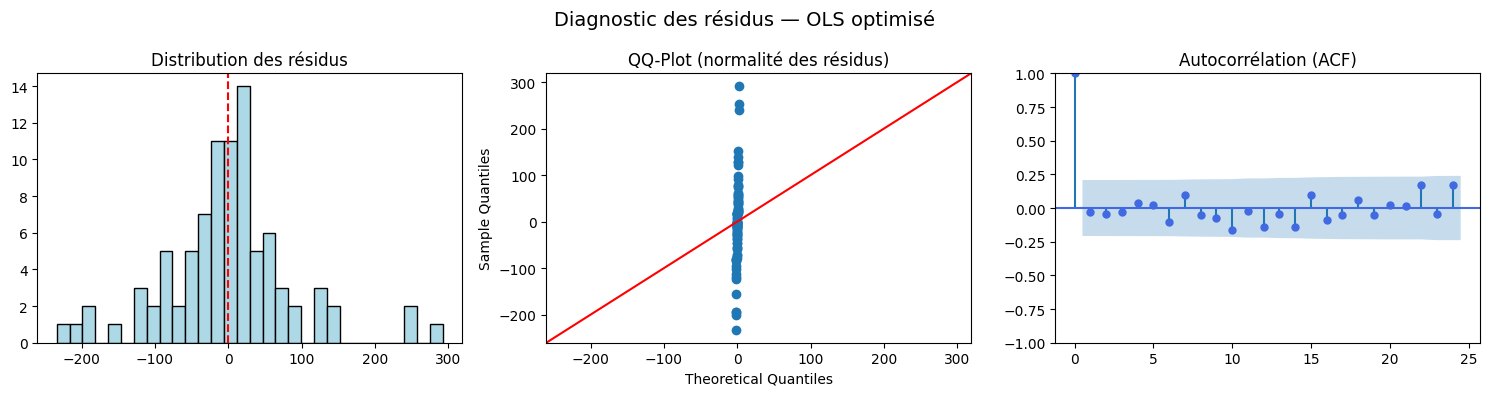

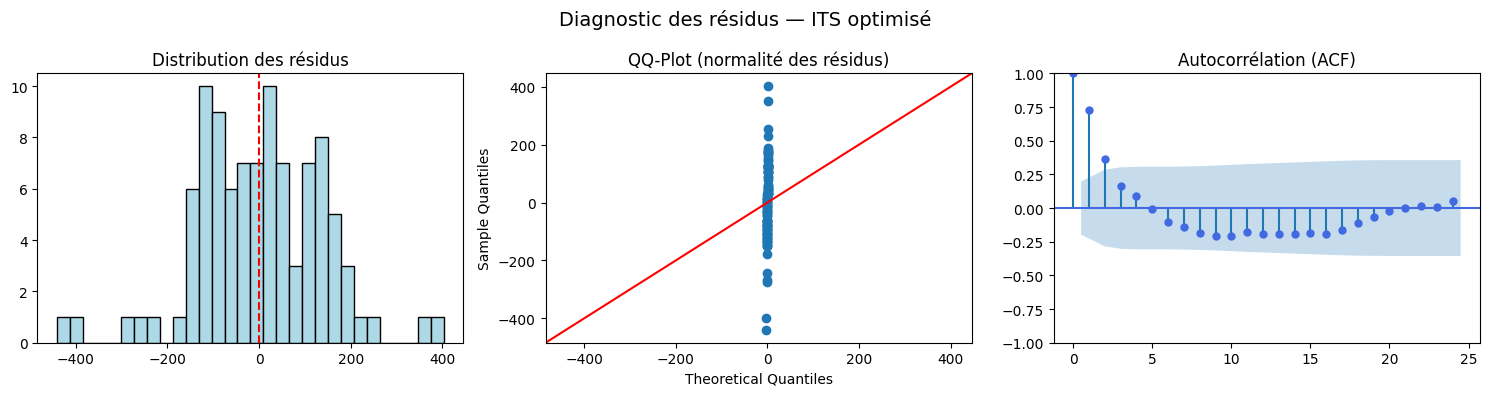

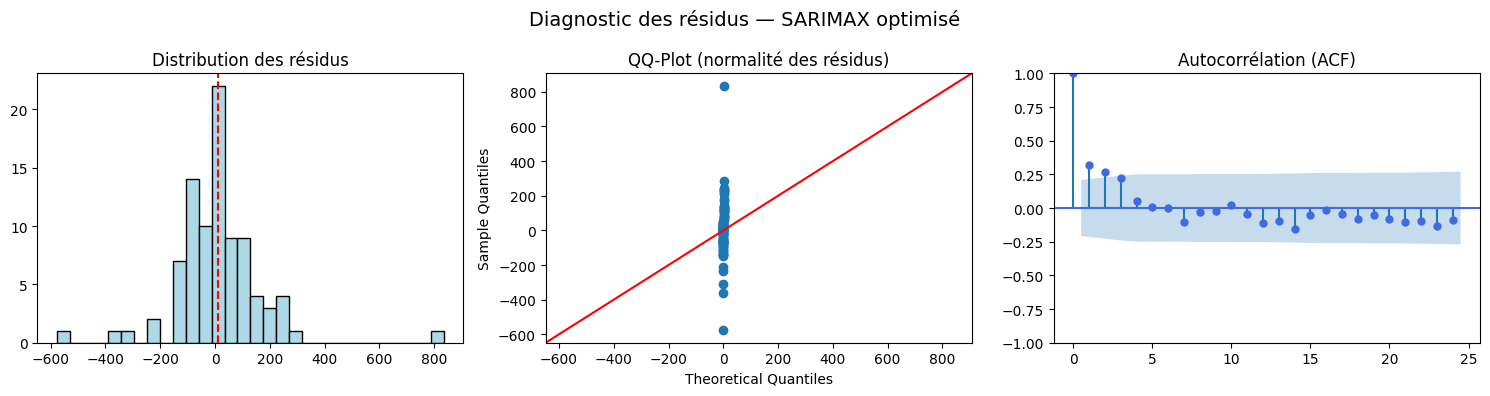

In [11]:
# ==========================================
# 🧱 BLOC 7 — Diagnostic des résidus
# ==========================================
import scipy.stats as stats
import matplotlib.pyplot as plt

def diagnostic_residus(resid, title=""):
    resid = pd.Series(resid).dropna()
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    # 1️⃣ Distribution
    axes[0].hist(resid, bins=30, color="lightblue", edgecolor="k")
    axes[0].set_title("Distribution des résidus")
    axes[0].axvline(resid.mean(), color="red", linestyle="--")

    # 2️⃣ QQ-plot
    sm.qqplot(resid, line="45", ax=axes[1], color="navy")
    axes[1].set_title("QQ-Plot (normalité des résidus)")

    # 3️⃣ Autocorrélation
    sm.graphics.tsa.plot_acf(resid, lags=24, ax=axes[2], color="royalblue")
    axes[2].set_title("Autocorrélation (ACF)")

    plt.suptitle(f"Diagnostic des résidus — {title}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Diagnostic OLS optimisé
diagnostic_residus(ols_opt.resid, "OLS optimisé")

# Diagnostic ITS optimisé
diagnostic_residus(its_best.resid, "ITS optimisé")

# Diagnostic SARIMAX optimisé
diagnostic_residus(sarimax_best.resid, "SARIMAX optimisé")


In [21]:
# Crée une copie brute de la base avant lag
X_base_raw = merge_exog(rsv, vac, work, cov_nat)


In [22]:
# ==========================================
# 🧱 BLOC 9 — Sensibilité des lags
# ==========================================
results = []
for lv, lm, lw in product(range(2,10), range(4,13), range(4,13)):
    X_tmp = build_model_matrix(X_base_raw, lags=(lv,lm,lw), mask_vars=mask_vars)
    df_tmp = rsv.set_index("date_monday")[["RSV"]].join(X_tmp).dropna()
    if len(df_tmp) < 40: continue
    m = sm.OLS(df_tmp["RSV"], sm.add_constant(df_tmp[X_cols_base])).fit()
    results.append({"lag_vac": lv, "lag_mnp": lm, "lag_work": lw, "R2_adj": m.rsquared_adj})

res_df = pd.DataFrame(results)
fig = px.scatter_3d(
    res_df, x="lag_vac", y="lag_mnp", z="lag_work",
    color="R2_adj", color_continuous_scale="Viridis",
    title="Effet des lags (vaccination / MNP / travail) sur R² ajusté"
)
fig.update_traces(marker=dict(size=5))
fig.show()

# Interprétation :
# - Identifier la combinaison de lags où R²_adj est maximal (valeur stable = modèle robuste).


In [23]:
print("Colonnes de X_base :", X_base.columns.tolist())
print("work shape:", work.shape)
print("indicateurs uniques :", gm["indicator"].unique()[:10])


Colonnes de X_base : ['const', 'cov12_lag', 'MNP_lag', 'work_lag', 'sin52', 'cos52']
work shape: (140, 3)
indicateurs uniques : ['grocery and pharmacy' 'parks' 'residential' 'retail and recreation'
 'transit stations' 'workplaces']


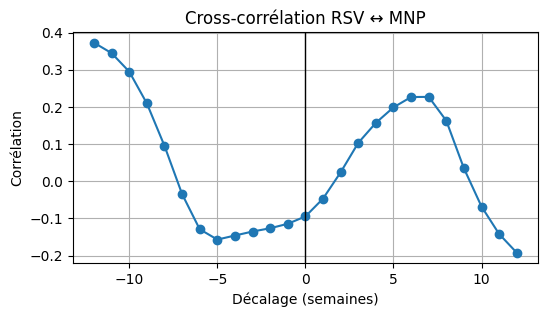

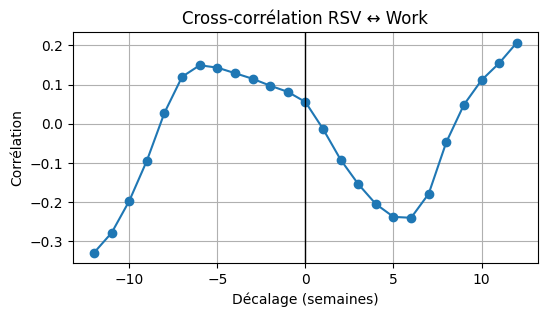

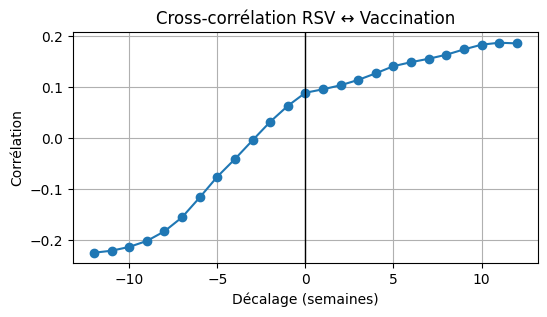

In [13]:
# ==========================================
# 🧱 BLOC 10 — Corrélation croisée RSV vs comportements
# ==========================================
import matplotlib.pyplot as plt

def plot_crosscorr(x, y, var_name, max_lag=12):
    lags = np.arange(-max_lag, max_lag+1)
    corr = [x.corr(y.shift(l)) for l in lags]
    plt.figure(figsize=(6,3))
    plt.plot(lags, corr, marker='o')
    plt.axvline(0, color="black", lw=1)
    plt.title(f"Cross-corrélation RSV ↔ {var_name}")
    plt.xlabel("Décalage (semaines)")
    plt.ylabel("Corrélation")
    plt.grid(True)
    plt.show()

plot_crosscorr(df_base["RSV"], df_base["MNP_lag"], "MNP")
plot_crosscorr(df_base["RSV"], df_base["work_lag"], "Work")
plot_crosscorr(df_base["RSV"], df_base["cov12_lag"], "Vaccination")


In [14]:
# ==========================================
# 🧱 BLOC 12 — Préparation des scénarios contrefactuels
# ==========================================
df_scen = df_opt.copy()

# 1️⃣ NoCOVID
df_no_covid = df_scen.copy()
df_no_covid["post_covid"] = 0
df_no_covid["t_post_covid"] = 0
df_no_covid["Scenario"] = "NoCOVID"

# 2️⃣ KeepMNP (MNP figé à son maximum)
max_mnp = df_scen["MNP_lag"].max()
df_keep_mnp = df_scen.copy()
df_keep_mnp["MNP_lag"] = max_mnp
df_keep_mnp["Scenario"] = "KeepMNP"

# 3️⃣ NoVaccine
df_no_vacc = df_scen.copy()
df_no_vacc["cov12_lag"] = 0
df_no_vacc["vacc_x_mnp"] = 0
df_no_vacc["Scenario"] = "NoVaccine"

# Fusion des scénarios
df_all_scen = pd.concat([df_scen.assign(Scenario="Réel"), df_no_covid, df_keep_mnp, df_no_vacc])
print("✅ Scénarios contrefactuels préparés : Réel / NoCOVID / KeepMNP / NoVaccine")


✅ Scénarios contrefactuels préparés : Réel / NoCOVID / KeepMNP / NoVaccine


In [15]:
# ==========================================
# 🧱 BLOC 13 — Heatmap des performances multi-modèles
# ==========================================
metrics = model_perf.set_index("Modèle")[["R²_adj", "AIC", "BIC", "Durbin-Watson"]]
fig = px.imshow(
    metrics,
    text_auto=".2f",
    color_continuous_scale="RdYlGn_r",
    title="Synthèse multi-modèles — performances comparées",
    aspect="auto"
)
fig.show()
